## Facultad de Ciencias Exactas, Ingeniería y Agrimensura - UNR
## Tecnicatura Universitaria en Inteligencia Artificial.

Trabajo Práctico Final: Procesamiento de Lenguaje Natural.

Crenna, Giuliano. Legajo: C-7438/1.

**Docentes:**
* Manson, Juan Pablo.
* Geary, Alan.
* Sollberger, Dolores.
* Ferrucci, Costantino.

Fecha de Entrega: 18 de diciembre de 2024.

In [1]:
!pip install requests beautifulsoup4 chromadb PyPDF2 sentence-transformers transformers huggingface_hub  llama-cpp-python jinja2 python-decouple openai==1.56.1 httpx==0.27.2 SpeechRecognition pydub youtube-transcript-api jinja2 llm-templates litellm[proxy] wikipedia llama-index-llms-ollama llama-index redis redisgraph unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 MB 6.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 6.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of transformers to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of llama-index-llms-openai to determine which version is compatible with other requirements. This could take a while.
INFO: pip is stil

# 1. Setup
Preparacion de directorios y decarga de documentos correspondientes.

In [2]:
!mkdir data
!chmod 777 data

### Descargar archivos de datos

Este bloque de código cambia al directorio `data` y descarga varios archivos de datos necesarios para el proyecto desde repositorios en GitHub y otros enlaces. Los archivos incluyen reseñas, reglas del juego en formato PDF, un archivo CSV con preguntas y respuestas, un archivo de audio y un archivo de entorno (.env) para la configuración del proyecto.

- Se descargan los siguientes archivos:
  - **resena.txt**: Una reseña de texto.
  - **lost-ruins-of-arnak-rules-es.pdf**: Reglas del juego "Lost Ruins of Arnak" en español.
  - **preguntas_y_respuestas.csv**: Un archivo CSV con preguntas y respuestas.
  - **arnak_resena_audio.m4a**: Un archivo de audio con la reseña de "Lost Ruins of Arnak".
  - **lost-ruins-of-arnak-rules-en.pdf**: Reglas del juego en inglés.

In [3]:
%cd data
!wget https://raw.githubusercontent.com/giulicrenna/TUIA-NLP/refs/heads/main/data/resena.txt
!wget https://raw.githubusercontent.com/giulicrenna/TUIA-NLP/main/data/lost-ruins-of-arnak-rules-es.pdf
!wget https://raw.githubusercontent.com/giulicrenna/TUIA-NLP/refs/heads/main/data/preguntas_y_respuestas.csv
!wget https://raw.githubusercontent.com/giulicrenna/TUIA-NLP/refs/heads/main/data/arnak_resena_audio.m4a
!wget https://czechgames.com/files/rules/lost-ruins-of-arnak-rules-en.pdf
%cd ..
!wget https://raw.githubusercontent.com/giulicrenna/TUIA-NLP/refs/heads/main/.env

/content/data
--2024-12-28 13:31:49--  https://raw.githubusercontent.com/giulicrenna/TUIA-NLP/refs/heads/main/data/resena.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659 (20K) [text/plain]
Saving to: ‘resena.txt’

resena.txt          100%[===================>]  20.17K  --.-KB/s    in 0s      

2024-12-28 13:31:49 (97.1 MB/s) - ‘resena.txt’ saved [20659/20659]

--2024-12-28 13:31:49--  https://raw.githubusercontent.com/giulicrenna/TUIA-NLP/main/data/lost-ruins-of-arnak-rules-es.pdf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK


### Instalación y configuración de Redis Stack

Este bloque de código realiza la instalación de Redis Stack en un entorno Ubuntu. Los pasos incluyen la descarga de dependencias, la instalación de un paquete `.deb` y la configuración de Redis Stack para que se ejecute como un servicio en segundo plano.

1. **Descarga de la librería `libssl1.1`**:
   - Se descarga el paquete `libssl1.1_1.1.1f-1ubuntu2_amd64.deb` desde un repositorio de Ubuntu.
   
2. **Instalación de `libssl1.1`**:
   - Se instala el paquete descargado utilizando `dpkg`.

3. **Descarga de Redis Stack Server**:
   - Se descarga el archivo comprimido de Redis Stack Server desde el repositorio oficial.

4. **Extracción del archivo descargado**:
   - Se extrae el archivo `.tar.gz` de Redis Stack Server.

5. **Ejecución de Redis Stack Server**:
   - Finalmente, se inicia el servidor de Redis Stack en segundo plano utilizando el parámetro `--daemonize yes`.


In [4]:
!wget http://nz2.archive.ubuntu.com/ubuntu/pool/main/o/openssl/libssl1.1_1.1.1f-1ubuntu2_amd64.deb
!sudo dpkg -i libssl1.1_1.1.1f-1ubuntu2_amd64.deb
!curl -fsSL https://packages.redis.io/redis-stack/redis-stack-server-6.2.6-v7.focal.x86_64.tar.gz -o redis-stack-server.tar.gz
!tar -xvf redis-stack-server.tar.gz
!./redis-stack-server-6.2.6-v7/bin/redis-stack-server --daemonize yes

--2024-12-28 13:32:00--  http://nz2.archive.ubuntu.com/ubuntu/pool/main/o/openssl/libssl1.1_1.1.1f-1ubuntu2_amd64.deb
Resolving nz2.archive.ubuntu.com (nz2.archive.ubuntu.com)... 185.125.190.83, 91.189.91.82, 185.125.190.82, ...
Connecting to nz2.archive.ubuntu.com (nz2.archive.ubuntu.com)|185.125.190.83|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1318204 (1.3M) [application/vnd.debian.binary-package]
Saving to: ‘libssl1.1_1.1.1f-1ubuntu2_amd64.deb’

libssl1.1_1.1.1f-1u 100%[===================>]   1.26M  1.10MB/s    in 1.1s    

2024-12-28 13:32:01 (1.10 MB/s) - ‘libssl1.1_1.1.1f-1ubuntu2_amd64.deb’ saved [1318204/1318204]

Selecting previously unselected package libssl1.1:amd64.
(Reading database ... 123634 files and directories currently installed.)
Preparing to unpack libssl1.1_1.1.1f-1ubuntu2_amd64.deb ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2) ...
Setting up libssl1.1:amd64 (1.1.1f-1ubuntu2) ...
debconf: unable to initialize frontend: Dialog
debc

In [70]:
# Librerías de uso general
import os
import json
import requests
import dotenv
import re
import numpy as np
import seaborn as sns
from google.colab import userdata

#Librerías para el preprocesamiento de datos
import csv
import chromadb
import wikipedia
import pandas as pd
import speech_recognition as sr
import redis
import matplotlib.pyplot as plt
import networkx as nx
from unidecode import unidecode
from redisgraph import Graph, Node, Edge
from youtube_transcript_api import YouTubeTranscriptApi
from pydub import AudioSegment
from PyPDF2 import PdfReader
from bs4 import BeautifulSoup
from chromadb.config import Settings

# Librerías para el clasificador
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, classification_report, recall_score, f1_score

# Librerías para la creación del modelo con Random Forest
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Librerias para la creación del RAG
import torch
from openai import OpenAI
from decouple import config
from transformers import pipeline
from huggingface_hub import hf_hub_download
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Librerías para el agente
from llama_index.core import Settings
from llama_index.llms.ollama import Ollama
from llama_index.core.tools import FunctionTool
from llama_index.core.agent.react.formatter import ReActChatFormatter
from llama_index.core.agent import ReActAgent

In [6]:
import warnings
warnings.filterwarnings('ignore')

# 1.0 Preparación de los datos

## 1.1 Scrapping
Se realiza el scrapping de las páginas donde se encuentran la información requerida del juego.

In [7]:
def save_webpage_text(url, output_file):
    try:
        response = requests.get(url)
        response.raise_for_status()

        soup = BeautifulSoup(response.content, 'html.parser')

        full_text = soup.get_text(separator="\n", strip=True)

        with open(output_file, 'w', encoding='utf-8') as file:
          if not os.path.exists(output_file):
            file.write(full_text)

        print(f"Texto extraído y guardado en {output_file}")
    except Exception as e:
        print(f"Error: {e}")

In [8]:
save_webpage_text(url="https://misutmeeple.com/2021/04/resena-las-ruinas-perdidas-de-arnak/",
                  output_file=os.path.join(os.getcwd(), 'data', 'resena.txt'))

Texto extraído y guardado en /content/data/resena.txt


In [9]:
save_webpage_text(url="https://donmeeple.com/ruinas-perdidas-arnak-juego-mesa/",
                  output_file=os.path.join(os.getcwd(), 'data', 'resena_2.txt'))

Texto extraído y guardado en /content/data/resena_2.txt


In [10]:
save_webpage_text(url="https://mishigeek.com/lost-ruins-of-arnak-resena-en-espanol/",
                  output_file=os.path.join(os.getcwd(), 'data', 'reglas.txt'))

Error: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


## 1.2 Creación de la base de datos vectorial
Creo todas las funciones necesarias para facilitar el preprocesado de los datos.

### Funciones para Procesamiento de Archivos y Modelos

Este bloque de código incluye la configuración de un modelo de embeddings y varias funciones para procesar diferentes tipos de archivos (CSV, texto, PDF, audio) y realizar transcripción desde un video de YouTube.

1. **Configuración del modelo de embeddings**:
   - Se utiliza el modelo `all-MiniLM-L6-v2` de **SentenceTransformer** para crear representaciones vectoriales de texto.

2. **Conexión con la base de datos `chromadb`**:
   - Se crea un cliente persistente de `chromadb`, que se conecta a un directorio `vector` dentro del directorio `data`, y se obtiene o crea una colección llamada "arnak".

3. **Lectura de archivos CSV**:
   - La función `read_csv_file` lee un archivo CSV y devuelve una lista de diccionarios, donde cada diccionario corresponde a una fila del archivo.

4. **Lectura de archivos de texto**:
   - La función `read_text_file` lee el contenido de un archivo de texto y lo devuelve como una cadena.

5. **Lectura de archivos PDF**:
   - La función `read_pdf_file` extrae el texto de cada página de un archivo PDF y lo concatena en una cadena.

6. **Transcripción de video de YouTube**:
   - La función `transcribir` toma una URL de un video de YouTube, extrae el ID del video y obtiene la transcripción en los idiomas especificados (español o inglés).

7. **División de archivos de audio**:
   - La función `split_audio` toma un archivo de audio y lo divide en fragmentos más pequeños (por defecto, de 30 segundos), exportándolos como archivos `.wav`.


In [11]:
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [12]:
client = chromadb.PersistentClient(path=os.path.join('data', 'vector'))

collection = client.get_or_create_collection(name="arnak")

In [13]:
def read_csv_file(file_path: str) -> list[dict]:
    """
    Lee un archivo CSV y devuelve una lista de diccionarios, donde cada diccionario representa una fila.
    """
    rows = []

    with open(file_path, 'r', encoding='utf-8') as file:
        csv_reader = csv.DictReader(file)
        for row in csv_reader:
            rows.append(row)

    return rows

In [14]:
def read_text_file(file_path: str) -> str:
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

In [15]:
def read_pdf_file(file_path: str) -> str:
    pdf_reader = PdfReader(file_path)
    text = ""
    for page in pdf_reader.pages:
        text += page.extract_text()
    return text

In [16]:
def transcribir(url: str) -> str:
    try:
        video_id_match = re.search(r"v=([a-zA-Z0-9_-]+)", url)
        if video_id_match:
            video_id = video_id_match.group(1)
        else:
            raise ValueError("No se pudo extraer el ID del video de la URL.")

        transcript = YouTubeTranscriptApi.get_transcript(video_id, languages=('es', 'en'))
        text = " ".join([entry['text'] for entry in transcript])

        text = text.replace('\n', ' ').strip()

        return text

    except Exception as e:
        print("Error:", e)


In [17]:
def split_audio(file_path: str, chunk_length_ms: int = 30000):
    """
    Divide un archivo de audio en fragmentos más pequeños.
    """
    audio = AudioSegment.from_file(file_path)
    chunks = []

    for i, start in enumerate(range(0, len(audio), chunk_length_ms)):
        chunk = audio[start:start + chunk_length_ms]
        chunk_name = f"chunk_{i}.wav"
        chunk.export(chunk_name, format="wav")
        chunks.append(chunk_name)

    return chunks

In [18]:
def m4a_to_text(chunks: list) -> str:
    """
    Convierte un archivo de audio .m4a a texto.
    """
    recognizer = sr.Recognizer()

    text_result = ""

    for i, chunk_path in enumerate(chunks):
        with sr.AudioFile(chunk_path) as source:
            print(f"Analizando fragmento {i + 1}...")
            audio_data = recognizer.record(source)
            try:
                text_result += recognizer.recognize_google(audio_data, language="es-ES") + " "
            except sr.UnknownValueError:
                text_result += "[Incomprensible] "
            os.remove(chunk_path)

    return text_result

In [19]:
def split_into_chunks(text: str, chunk_size: int = 500, chunk_overlap: int = 100) -> list[str]:
    clean_text = "\n".join(
        line.strip() for line in text.splitlines() if line.strip()
    )

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=["\n\n", "\n", "."]
    )

    chunks = text_splitter.split_text(clean_text)

    return chunks

In [20]:
def load_csv_into_to_chromadb(csv_path: str) -> None:
    """
    Lee un archivo CSV, transforma los datos y los indexa en una colección de ChromaDB.
    """
    csv_data = read_csv_file(csv_path)

    # Formatear los datos para ChromaDB (id y texto)
    for idx, row in enumerate(csv_data):
        question = row.get("Pregunta", "")  # Asegúrate de que esta columna exista en tu CSV
        answer = row.get("Respuesta", "")   # Asegúrate de que esta columna exista en tu CSV
        if question and answer:
            collection.add(
                ids=[f"doc_{idx}"],
                documents=[question],
                metadatas=[{"answer": answer}]
            )

In [21]:
def clean_chromadb(collection_name: str = None):
  try:
      client.delete_collection(collection_name)
      print(f"Colleccion '{collection_name}' borrada.")
  except Exception as e:
      print(f"Error eliminando '{collection_name}': {e}")

In [22]:
def insert_into_chromadb(collection: str, chunks: list[str], embedding_model) -> None:
    for i, chunk in enumerate(chunks):
        embedding = embedding_model.encode(chunk)
        collection.add(
            documents=[chunk],
            metadatas=[{"chunk_id": i}],
            ids=[f"doc_{i}"]
        )

In [23]:
def process_and_store(file_paths: str) -> None:
  for file_path in file_paths:
      print(f'Embebiendo datos en la BD Vectorial.\n', '*'*50)
      try:
          print(f'Procesando: {file_path}')
          if file_path.endswith('.txt'):
              text = read_text_file(file_path)
          elif file_path.endswith('.pdf'):
              text = read_pdf_file(file_path)
          elif file_path.endswith('.csv'):
              load_csv_into_to_chromadb(file_path)
              text = ""
          elif 'https://' in file_path:
              text = transcribir(file_path)
          else:
            raise ValueError(f"Formato no soportado: {file_path}")
          chunks = split_into_chunks(text)
          insert_into_chromadb(collection, chunks, embedding_model)
      except Exception as e:
        print(e)
        pass

In [24]:
file_paths: list[str] = [os.path.join(os.getcwd(), 'data', 'resena.txt'),
                         os.path.join(os.getcwd(), 'data', 'preguntas_y_respuestas.csv'),
                         os.path.join(os.getcwd(), 'data', 'lost-ruins-of-arnak-rules-en.pdf'),
                         os.path.join(os.getcwd(), 'data', 'lost-ruins-of-arnak-rules-es.pdf'),
                         'https://www.youtube.com/watch?v=FpKxw-VwZSg',
                         'https://www.youtube.com/watch?v=lY_x3mbLRsY']

In [25]:
process_and_store(file_paths)

Embebiendo datos en la BD Vectorial.
 **************************************************
Procesando: /content/data/resena.txt
Embebiendo datos en la BD Vectorial.
 **************************************************
Procesando: /content/data/preguntas_y_respuestas.csv


/root/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:20<00:00, 4.04MiB/s]


Embebiendo datos en la BD Vectorial.
 **************************************************
Procesando: /content/data/lost-ruins-of-arnak-rules-en.pdf


Embebiendo datos en la BD Vectorial.
 **************************************************
Procesando: /content/data/lost-ruins-of-arnak-rules-es.pdf


Embebiendo datos en la BD Vectorial.
 **************************************************
Procesando: https://www.youtube.com/watch?v=FpKxw-VwZSg


Embebiendo datos en la BD Vectorial.
 **************************************************
Procesando: https://www.youtube.com/watch?v=lY_x3mbLRsY


## 1.3 Creación de la base de datos de grafos


### Conexión y configuración de Redis con un gráfico

Este bloque de código establece una conexión con un servidor Redis y crea un gráfico para almacenar y manejar datos de manera eficiente.



In [26]:
redis_client = redis.Redis(host='localhost', port=6379)

redis_client.flushall()

graph = Graph("arnak", redis_client)

In [27]:
def define_relation(label: str) -> str:
    """
    Define la relación entre el nodo principal y otros nodos según su label.
    """
    if label == "Lugar":
        return "Conecta"
    elif label == "Mecánica":
        return "Usa"
    elif label == "Entidad":
        return "Interacciona_con"
    elif label == "Recurso":
        return "Genera"
    elif label == "Guardian":
        return "Custodia"
    return None

In [28]:
def create_arnak_graph(graph: Graph) -> None:
    """
    Crea el grafo basado en los elementos de Las Ruinas Perdidas de Arnak.
    """
    main_node = Node(label="Juego", properties={"name": "Ruinas Perdidas de Arnak"})
    graph.add_node(main_node)

    nodes = {"Ruinas Perdidas de Arnak": main_node}

    data = {
        "Lugar": ["Base", "Templo del Pájaro", "Templo de la Serpiente"],
        "Mecánica": ["Exploración", "Arqueología", "Investigación"],
        "Entidad": ["Jugadores", "Ayudantes", "Guardianes"],
        "Recurso": ["Artefactos", "Ídolos", "Puntas de flecha", "Monedas", "Brújulas"],
    }

    for label, nombres in data.items():
        for nombre in nombres:
            node = Node(label=label, properties={"name": nombre})
            graph.add_node(node)
            nodes[nombre] = node

            relation = define_relation(label)
            if relation:
                graph.add_edge(Edge(main_node, relation, node))

    lugares = data["Lugar"]
    for i in range(len(lugares) - 1):
        if lugares[i] in nodes and lugares[i + 1] in nodes:
            graph.add_edge(Edge(nodes[lugares[i]], "Conecta", nodes[lugares[i + 1]]))

    if "Guardianes" in nodes:
        guardian_node = nodes["Guardianes"]
        for templo in ["Templo del Pájaro", "Templo de la Serpiente"]:
            if templo in nodes:
                graph.add_edge(Edge(guardian_node, "Custodia", nodes[templo]))

    if "Exploración" in nodes:
        exploracion_node = nodes["Exploración"]
        recursos = data["Recurso"]
        for recurso in recursos:
            if recurso in nodes:
                graph.add_edge(Edge(exploracion_node, "Genera", nodes[recurso]))

    try:
      graph.commit()
    except Exception as e:
      pass

    print("Grafo de Las Ruinas Perdidas de Arnak creado exitosamente.")

In [29]:
create_arnak_graph(graph)

Grafo de Las Ruinas Perdidas de Arnak creado exitosamente.


## 1.4 Funciones de consulta

In [30]:
def get_embedding(query: str, embedding_model) -> list[float]:
    return embedding_model.encode(query)

In [31]:
def query_chromadb(collection: str, query: str, embedding_model, top_k: int=3) -> list[list[float]]:
    embedding = get_embedding(query, embedding_model)
    results = collection.query(
        query_embeddings=[embedding],
        n_results=top_k
    )
    return results

In [32]:
def display_results(results):
    for i, document in enumerate(results['documents'][0]):
        print(f"Resultado {i+1}:")
        print(f"Texto: {document}")
        print(f"Metadata: {results['metadatas'][0][i]}")
        print(f"ID: {results['ids'][0][i]}")
        print("-" * 50)

In [33]:
querys: list[str] = ["Cuanto cuesta comprar el juego?",
                     "Como se juega?",
                     "Cantidad de jugadores"]

for query in querys:
  print(f"Query: {query}")
  results = query_chromadb(collection, query, embedding_model, 1)

  display_results(results)

Query: Cuanto cuesta comprar el juego?
Resultado 1:
Texto: ¿Cuánto cuesta el juego en el mercado?
Metadata: {'answer': '59,99€.'}
ID: doc_19
--------------------------------------------------
Query: Como se juega?
Resultado 1:
Texto: ¿Qué tipo de caja tiene el juego?
Metadata: {'answer': 'Una caja rectangular de dos piezas (tapa y fondo).'}
ID: doc_20
--------------------------------------------------
Query: Cantidad de jugadores
Resultado 1:
Texto: ¿Cuál es el rango de jugadores permitido?
Metadata: {'answer': 'De 1 a 4 jugadores.'}
ID: doc_14
--------------------------------------------------


# 2.0 Creaciones de los chats

## 2.1 Funciones generales

### Función de Augmentación de Datos para Chatbot

Este bloque de código define una función que enriquece un prompt de chat con información relevante extraída de una base de datos vectorial (utilizando **Chromadb**) para mejorar las respuestas del chatbot.

**`augment_with_retrieved_data`**:
   - Esta función toma como entrada un prompt de chat (`chat_prompt`), una colección de datos en **Chromadb**, una consulta de texto (`query`), un modelo de embeddings (`embedding_model`), y un parámetro opcional `top_k` que determina cuántos resultados relevantes recuperar (por defecto es 3).
   - La función realiza una búsqueda en la base de datos vectorial utilizando la función `query_chromadb` (que no se muestra aquí) y extrae los resultados más relevantes para la consulta.
   - Los resultados relevantes se combinan en una cadena de texto y se añaden al prompt como un mensaje del tipo "system". Este mensaje contiene la información adicional que ayudará al chatbot a generar respuestas más informadas.


In [34]:
def get_key() -> str:
  dotenv.load_dotenv()
  key = os.getenv('AIK_HEADER') + os.getenv('AIK_CHUNK_1') + os.getenv('AIK_CHUNK_2') + os.getenv('AIK_CHUNK_3')

  return key

In [35]:
def augment_with_retrieved_data(chat_prompt: list, collection, query: str, embedding_model, top_k: int = 3):
    """
    Embebe información relevante de la base vectorial al prompt.
    """
    retrieval_results = query_chromadb(collection, query, embedding_model, top_k)

    relevant_data = " ".join(result for result in retrieval_results["documents"][0])

    chat_prompt.append({
        "role": "system",
        "content": f"Información adicional relevante: {relevant_data}"
    })

    return chat_prompt

In [36]:
mensajes = [
    {
        "role": "system",
        "content": "Sos un chatbot que se encarga de brindar informacion sobre el juego Las ruinas perdidas de Arnak, no dar respuestas largas",
    }
]

In [37]:
preguntas = [
    "¿Qué es el objetivo principal del juego Las Ruinas Perdidas de Arnak?",
    "¿Cuáles son las mecánicas principales de Las Ruinas Perdidas de Arnak?",
    "¿Cómo se juega el modo de exploración en Las Ruinas Perdidas de Arnak?",
    "¿Cuántos jugadores pueden participar en Las Ruinas Perdidas de Arnak?",
    "¿Cuál es la duración aproximada de una partida?",
    "¿Qué componentes incluye el juego?",
    "¿Qué tan complejo es aprender a jugar Las Ruinas Perdidas de Arnak?",
    "¿Existen expansiones o contenido adicional para el juego?",
    "¿Qué estrategia se recomienda al comenzar una partida?",
    "¿Dónde se pueden comprar Las Ruinas Perdidas de Arnak?"
]

## 2.2 Clasificador

In [38]:
classification_examples: pd.DataFrame = pd.DataFrame({
    "prompt": [
        "How do I play Lost Ruins of Arnak?", "What are the game rules for Lost Ruins of Arnak?", "Explain the rulebook for Lost Ruins of Arnak.",  #3
        "What happens if someone leaves the expedition?", "Can you explain the setup for Lost Ruins of Arnak?", "What is the objective of Lost Ruins of Arnak?", #3
        "What are the winning conditions in Lost Ruins of Arnak?", "How do I resolve conflicts in Lost Ruins of Arnak?", "What happens during a tie in Lost Ruins of Arnak?", #3
        "What is the sequence of turns in Lost Ruins of Arnak?", "What is the penalty for breaking a rule?", "Can you explain advanced rules for Lost Ruins of Arnak?", #3
        "What are common beginner mistakes in Lost Ruins of Arnak?", "How do I use special cards?", "What happens if a player leaves mid-game?", #3
        "Can I modify the rules of Lost Ruins of Arnak?", "How are disputes settled?", "What are the house rules options?", "Is there a time limit per turn?", #4

        "What is your opinion about Lost Ruins of Arnak?", "What do people say about Lost Ruins of Arnak?", "Are there any reviews available for Lost Ruins of Arnak?",
        "What do players think about Lost Ruins of Arnak?", "Is Lost Ruins of Arnak worth buying?", "What are the pros and cons of Lost Ruins of Arnak?",
        "What do reviewers say about the Lost Ruins of Arnak theme?", "Are there any complaints about Lost Ruins of Arnak?", "What are the most praised aspects of Lost Ruins of Arnak?",
        "What do experienced players think about Lost Ruins of Arnak?", "How does Lost Ruins of Arnak compare to other adventure games?", "What are the critical reviews highlighting?",
        "Is Lost Ruins of Arnak recommended for families?", "What are the reviews for expansions of Lost Ruins of Arnak?", "Does Lost Ruins of Arnak hold replay value?",
        "What is the most common feedback on Lost Ruins of Arnak?", "Are there any awards mentioned in reviews of Lost Ruins of Arnak?", "What are the opinions on the artwork of Lost Ruins of Arnak?",
        "How do players rate the components?", "What themes do players find immersive in Lost Ruins of Arnak?",

        "How is the gameplay of Lost Ruins of Arnak?", "What is the experience of playing Lost Ruins of Arnak?", "Is Lost Ruins of Arnak engaging?", "How does the game flow?",
        "How long does a typical game last?", "What strategies are effective in Lost Ruins of Arnak?", "Is Lost Ruins of Arnak beginner-friendly?",
        "What is the difficulty level of Lost Ruins of Arnak?", "Are there any memorable moments during gameplay?", "How does Lost Ruins of Arnak scale with more players?",
        "Is there downtime between turns?", "What is the best player count for Lost Ruins of Arnak?", "Are there cooperative elements in Lost Ruins of Arnak?",
        "How do expansions affect gameplay?", "Are there any hidden mechanics in Lost Ruins of Arnak?", "How does randomness affect gameplay in Lost Ruins of Arnak?",
        "What are the key decision points in Lost Ruins of Arnak?", "Does the game have replayability?", "Are there player elimination mechanics?",
        "How does Lost Ruins of Arnak balance different strategies?",

        "How many players played Lost Ruins of Arnak this month?", "What is the average rating of Lost Ruins of Arnak?", "How many items are available for trade in Lost Ruins of Arnak?",
        "What is the rank of Lost Ruins of Arnak?", "How many fans does Lost Ruins of Arnak have?", "How many people have Lost Ruins of Arnak on their wishlist?",
        "What is the overall rank of Lost Ruins of Arnak?", "What is the strategy rank of Lost Ruins of Arnak?", "How many page views does Lost Ruins of Arnak have?",
        "What is the standard deviation of ratings?", "How many copies of Lost Ruins of Arnak were sold last year?", "What is the retention rate of players in Lost Ruins of Arnak?",
        "What are the top-rated games in the same category?", "What is the growth rate of interest in Lost Ruins of Arnak?", "How many reviews mention the artwork of Lost Ruins of Arnak?",
        "What is the average playtime reported for Lost Ruins of Arnak?", "How does Lost Ruins of Arnak rank in its genre?", "What is the peak player count this year for Lost Ruins of Arnak?",
        "What is the percentage of positive reviews?", "How many expansions are available for Lost Ruins of Arnak?",

        "Who designed Lost Ruins of Arnak?", "Who published Lost Ruins of Arnak?", "What is the main mechanic of Lost Ruins of Arnak?", "What are the game categories for Lost Ruins of Arnak?",
        "Who is the author of Lost Ruins of Arnak?", "What is the theme of Lost Ruins of Arnak?", "Which company published Lost Ruins of Arnak?", "What is the inspiration behind the game mechanics?",
        "What are the awards won by Lost Ruins of Arnak?", "Who developed the expansion packs?", "What partnerships were involved in publishing Lost Ruins of Arnak?",
        "Who owns the intellectual property rights?", "What are the licensing details?", "Which designers collaborated on Lost Ruins of Arnak?",
        "What are the notable influences on Lost Ruins of Arnak?", "Who created the promotional material?"
    ],
    "label": [
        "rules", "rules", "rules", "rules", "rules", "rules", "rules", "rules", "rules", "rules", "rules", "rules",
        "rules", "rules", "rules", "rules", "rules", "rules", "rules", "rules", "rules", "rules", "rules", "rules",
        "review", "review", "review", "review", "review", "review", "review", "review", "review", "review", "review",
        "review", "review", "review", "review", "review", "review", "review", "review", "review", "review", "review",
        "gameplay", "gameplay", "gameplay", "gameplay", "gameplay", "gameplay", "gameplay", "gameplay", "gameplay",
        "gameplay", "gameplay", "gameplay", "gameplay", "gameplay", "gameplay", "gameplay", "gameplay", "gameplay",
        "gameplay", "gameplay", "stats", "stats", "stats", "stats", "stats", "stats", "stats", "stats", "stats",
        "stats", "stats", "stats", "stats", "stats", "stats", "stats", "stats", "stats", "stats", "graph", "graph",
        "graph", "graph", "graph", "graph", "graph", "graph", "graph", "graph"
    ]
})

In [39]:
classification_examples.sample(5)

,prompt,label
76,What is the peak player count this year for Lo...,stats
72,What is the growth rate of interest in Lost Ru...,stats
18,Is there a time limit per turn?,rules
5,What is the objective of Lost Ruins of Arnak?,rules
14,What happens if a player leaves mid-game?,rules


In [40]:
X_classification: pd.DataFrame = classification_examples[['prompt']]
X_classification = X_classification['prompt'].apply(lambda x: x.lower())

In [41]:
y_classification: pd.DataFrame = classification_examples[['label']]

X_train, X_test, y_train, y_test = train_test_split(X_classification, y_classification,stratify=classification_examples['label'], test_size=0.2, random_state=42)

In [42]:
classification_vectorized: TfidfVectorizer = TfidfVectorizer()
X_train_vectorized = classification_vectorized.fit_transform(X_train)
X_test_vectorized = classification_vectorized.transform(X_test)

In [43]:
modelo_LR = LogisticRegression(multi_class='multinomial', solver='lbfgs')
modelo_LR.fit(X_train_vectorized, y_train)

LogisticRegression(multi_class='multinomial')

In [44]:
y_pred_lr = modelo_LR.predict(X_test_vectorized)
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

    gameplay       0.29      0.50      0.36         4
       graph       0.00      0.00      0.00         2
      review       0.00      0.00      0.00         4
       rules       0.50      0.40      0.44         5
       stats       0.25      0.25      0.25         4

    accuracy                           0.26        19
   macro avg       0.21      0.23      0.21        19
weighted avg       0.24      0.26      0.25        19



## 2.3 Recuperación y Generación de Respuestas (RAG)

In [45]:
context = mensajes.copy()

In [46]:
def generate_text_with_openai(message):
  global context

  api_key = get_key()

  context = augment_with_retrieved_data(context, collection, message, embedding_model, 10)

  context.append({
      "role": "user",
      "content": message
  })

  client = OpenAI(api_key=api_key)

  response = client.chat.completions.create(model="gpt-3.5-turbo",
                                            messages=context)

  context.append(response.choices[0].message)

  print(f'User: {message}')
  print(f'Chat: {response.choices[0].message.content}')

  return response.choices[0].message.content

In [47]:
for pregunta in preguntas:
  generate_text_with_openai(pregunta)
  print('-'*50, '\n\n')

User: ¿Qué es el objetivo principal del juego Las Ruinas Perdidas de Arnak?
Chat: El objetivo principal del juego Las Ruinas Perdidas de Arnak es explorar una isla misteriosa, descubrir lugares ancestrales, investigar templos y ruinas, reclutar ayudantes, adquirir herramientas y artefactos, y enfrentarte a diversos desafíos arqueológicos para obtener la mayor cantidad de puntos de victoria al final de la partida. ¡Buena suerte en tu aventura!
-------------------------------------------------- 


User: ¿Cuáles son las mecánicas principales de Las Ruinas Perdidas de Arnak?
Chat: Las mecánicas principales de Las Ruinas Perdidas de Arnak incluyen el deck-building, la gestión de recursos, la exploración de la isla, la colocación de trabajadores, la resolución de desafíos, la colección de artefactos y herramientas, la adquisición de puntos de victoria y la competencia por obtener las mejores acciones disponibles en cada turno. ¡Espero que disfrutes del juego y desentierre muchas ruinas perdi

## 2.4 ChatBot con Random Forest

In [48]:
data = data = pd.read_csv(os.path.join(os.getcwd(), 'data', 'preguntas_y_respuestas.csv'))

In [49]:
data.sample(5)

,Pregunta,Respuesta
69,What is the main objective of the game?,To score the most victory points by exploring ...
28,¿Cuántos peones de arqueólogos recibe cada jug...,2 peones por jugador.
71,What types of cards are in the game?,"Artifacts, equipment, and fear cards."
119,What size are the game cards?,63.5×88 mm.
13,¿En qué año se publicó por primera vez el juego?,En 2020.


In [50]:
vectorizer = TfidfVectorizer(max_features=5000)

X = vectorizer.fit_transform(data["Pregunta"])

In [51]:
data["Etiqueta"] = data["Respuesta"].astype("category").cat.codes  # Codifica categorías

y = data["Etiqueta"]

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [53]:
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

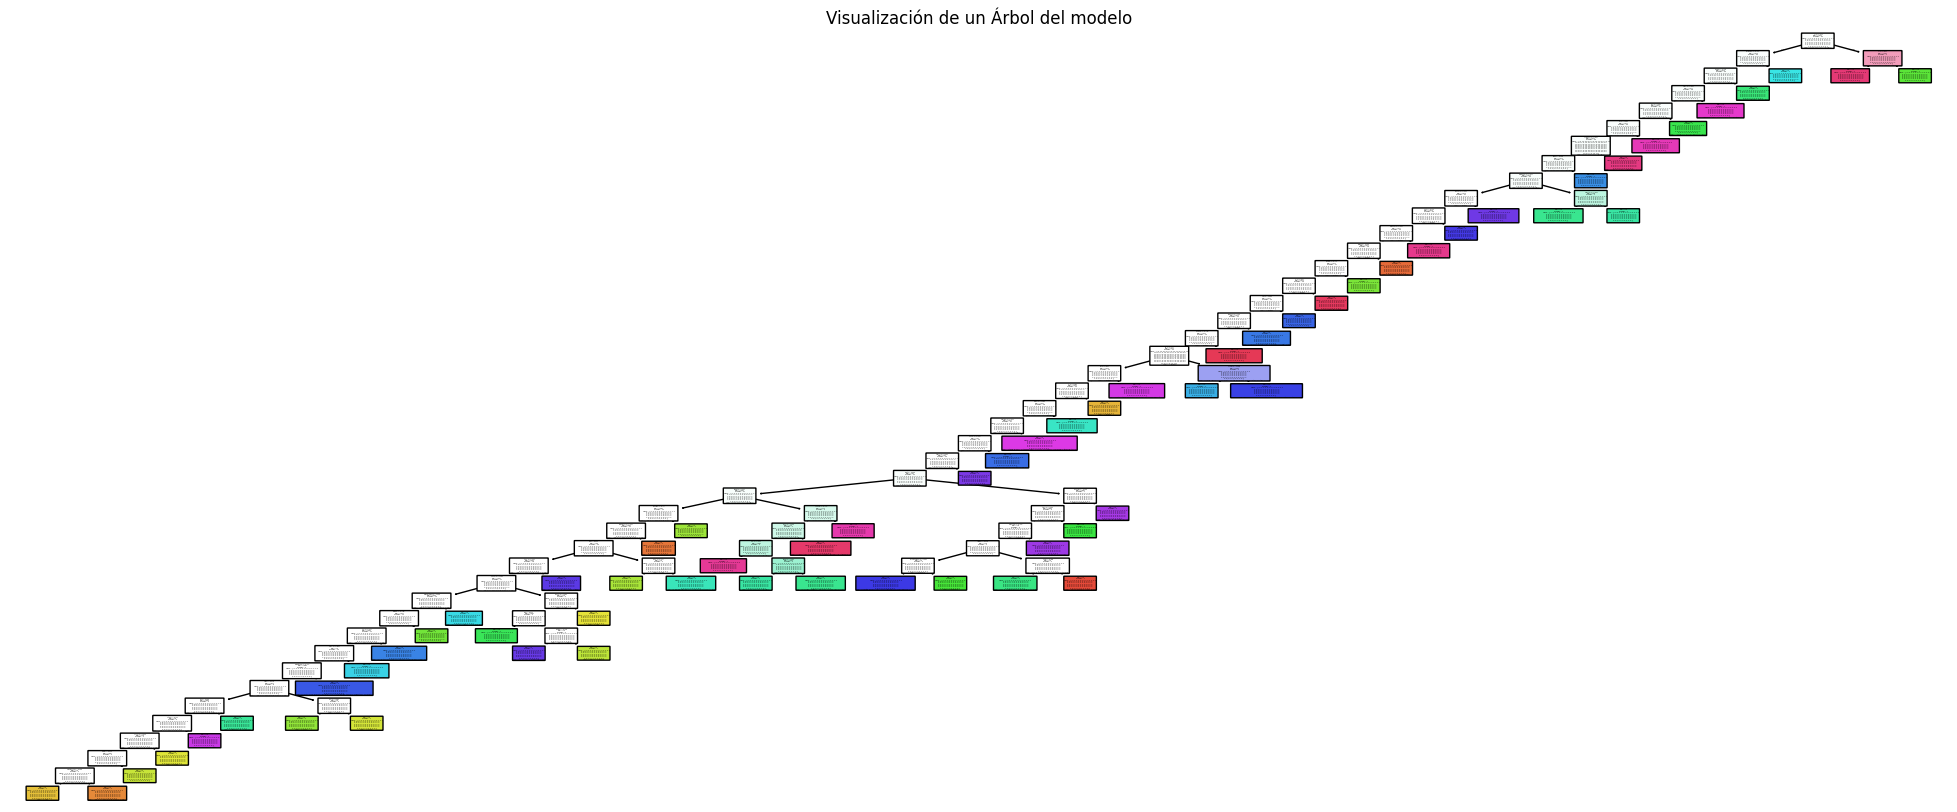

In [76]:
arbol = classifier.estimators_[0]

plt.figure(figsize=(25, 10))

plot_tree(arbol,
          feature_names=vectorizer.get_feature_names_out(),
          class_names=data["Respuesta"].astype("category").cat.categories,
          filled=True,
          rounded=True,
          fontsize=1)
plt.title("Visualización de un Árbol del modelo")

plt.show()

In [54]:
y_pred = classifier.predict(X_test)

unique_labels = sorted(y_test.unique())
target_names = data["Respuesta"].astype("category").cat.categories[unique_labels]

In [55]:
def predecir_respuesta(input_text: str) -> str:
    """
    Predice la respuesta para una pregunta usando el modelo Random Forest entrenado.
    """
    input_vector = vectorizer.transform([input_text])

    predicted_label = classifier.predict(input_vector)[0]

    respuesta = data["Respuesta"].astype("category").cat.categories[predicted_label]

    return respuesta

In [56]:
preguntas: list[str] = [
    "¿Cuántos tipos de tableros existen en el juego base?",
    "¿Qué tipo de objetos se encuentran en las cartas de artefactos?",
    "¿Cuántos ídolos pueden ser obtenidos durante el juego?",
    "¿Cuántas cartas de equipo se asignan a cada jugador al comenzar?",
    "¿Cuántos templos de diferentes colores están disponibles en el tablero?",
    "¿Qué mecánicas principales componen la jugabilidad de este juego?",
    "Cuantas losetas hay?"]

In [57]:
for pregunta in preguntas:
  print(f'Pregunta: {pregunta}')
  print(f'Respuesta: {predecir_respuesta(pregunta)}')
  print('-'*50, '\n\n')

Pregunta: ¿Cuántos tipos de tableros existen en el juego base?
Respuesta: Hay 12 ídolos en el tablero principal.
-------------------------------------------------- 


Pregunta: ¿Qué tipo de objetos se encuentran en las cartas de artefactos?
Respuesta: Botas, coches, barcos y aviones.
-------------------------------------------------- 


Pregunta: ¿Cuántos ídolos pueden ser obtenidos durante el juego?
Respuesta: Czech Games Edition (CGE).
-------------------------------------------------- 


Pregunta: ¿Cuántas cartas de equipo se asignan a cada jugador al comenzar?
Respuesta: Objetos antiguos que ayudan a los jugadores con habilidades únicas.
-------------------------------------------------- 


Pregunta: ¿Cuántos templos de diferentes colores están disponibles en el tablero?
Respuesta: 35 cartas.
-------------------------------------------------- 


Pregunta: ¿Qué mecánicas principales componen la jugabilidad de este juego?
Respuesta: Czech Games Edition (CGE).
------------------------

## 2.5 Chatbot en base a búsqueda semántica.

In [58]:
def busqueda_semantica(pregunta: str) -> str:
    pregunta_embedding = embedding_model.encode(pregunta)

    results = collection.query(
        query_embeddings=[pregunta_embedding],
        n_results=3
    )

    respuestas = [result["answer"] for result in results["metadatas"][0] if "answer" in result.keys()]
    respuestas_embeddings = [embedding_model.encode(respuesta) for respuesta in respuestas]

    similitudes = []

    for respuesta_embedding in respuestas_embeddings:
        sim = np.dot(pregunta_embedding, respuesta_embedding) / (np.linalg.norm(pregunta_embedding) * np.linalg.norm(respuesta_embedding))
        similitudes.append(sim)

    indices_ordenados = np.argsort(similitudes)[::-1]

    mejor_respuesta = respuestas[indices_ordenados[0]]

    return mejor_respuesta

In [59]:
preguntas: list[str] = ["Quien creó el juego las ruinas perdidas de arnak?",
                        "Cuales son los objetivo del juego",
                        "Cuantas cartas recibe cada jugador?",
                        "How many players can play the game?",
                        "How much it cost?"]

for pregunta in preguntas:
  print(f'Pregunta: {pregunta}')
  print(f'Respuesta: {busqueda_semantica(pregunta)}')
  print('-'*50, '\n\n')

Pregunta: Quien creó el juego las ruinas perdidas de arnak?
Respuesta: Michal Štach y Michaela Štachová.
-------------------------------------------------- 


Pregunta: Cuales son los objetivo del juego
Respuesta: Obtener la mayor cantidad de puntos de victoria explorando y desbloqueando áreas del tablero.
-------------------------------------------------- 


Pregunta: Cuantas cartas recibe cada jugador?
Respuesta: Cada jugador recibe 4 cartas de miedo y 2 cartas de equipo.
-------------------------------------------------- 


Pregunta: How many players can play the game?
Respuesta: From 1 to 4 players.
-------------------------------------------------- 


Pregunta: How much it cost?
Respuesta: 59.99€.
-------------------------------------------------- 




## 2.6 Comparacion de LLM con Random Forest

In [60]:
def obtener_embeddings(textos, embedding_model):
    """
    Obtiene los embeddings para una lista de textos utilizando el modelo de embeddings dado.
    """
    embeddings = embedding_model.encode(textos)
    return embeddings

def comparar_modelos_con_vectores(test_data, classifier, vectorizer, collection, embedding_model, context, respuestas_correctas):
    """
    Compara los resultados entre el modelo LLM y el modelo Random Forest utilizando similitud de coseno entre los vectores de embeddings.

    Args:
    - test_data: Un conjunto de preguntas de prueba.
    - classifier: El clasificador Random Forest entrenado.
    - vectorizer: El vectorizador para transformar las preguntas en vectores (como TfidfVectorizer).
    - collection: La colección de ChromaDB para la búsqueda de embeddings.
    - embedding_model: El modelo para generar embeddings de texto.
    - context: El contexto previo para la función `generate_text_with_openai`.
    - respuestas_correctas: La lista de respuestas correctas correspondientes a `test_data`.

    Returns:
    - Un diccionario con las métricas de desempeño de ambos clasificadores basados en similitud de coseno.
    """

    embeddings_correctas = obtener_embeddings(respuestas_correctas, embedding_model)

    respuestas_llm = []
    respuestas_rf = []

    similitudes_llm = []
    similitudes_rf = []

    for idx, pregunta in enumerate(test_data):
        respuesta_llm = generate_text_with_openai(pregunta)
        respuestas_llm.append(respuesta_llm)

        respuesta_rf = predecir_respuesta(pregunta)
        respuestas_rf.append(respuesta_rf)

        embeddings_llm = obtener_embeddings([respuesta_llm], embedding_model)
        embeddings_rf = obtener_embeddings([respuesta_rf], embedding_model)

        similitudes_llm.append(cosine_similarity(embeddings_llm, embeddings_correctas[idx].reshape(1, -1))[0][0])
        similitudes_rf.append(cosine_similarity(embeddings_rf, embeddings_correctas[idx].reshape(1, -1))[0][0])

    promedio_similitud_llm = np.mean(similitudes_llm)
    promedio_similitud_rf = np.mean(similitudes_rf)

    for idx, pregunta in enumerate(test_data):
        print(f"Pregunta: {pregunta}")
        print(f"Respuesta Correcta: {respuestas_correctas[idx]}")
        print(f"Respuesta LLM: {respuestas_llm[idx]}")
        print(f"Similitud LLM: {similitudes_llm[idx]:.4f}")
        print(f"Respuesta RF: {respuestas_rf[idx]}")
        print(f"Similitud RF: {similitudes_rf[idx]:.4f}")
        print("-" * 50)

    return {
        'similitud_promedio_llm': promedio_similitud_llm,
        'similitud_promedio_rf': promedio_similitud_rf,
        'respuestas_llm': respuestas_llm,
        'respuestas_rf': respuestas_rf
    }


In [61]:
test_data = [
    "Quien creó el juego las ruinas perdidas de arnak?",
    "Cuales son los objetivo del juego",
    "Cuantas cartas recibe cada jugador?",
    "How many players can play the game?",
    "How much it cost?"
]

respuestas = [
    "El juego 'Las Ruinas Perdidas de Arnak' fue creado por Mín y Elisabeth Hargrave, y publicado por la editorial Czech Games Edition.",
    "El objetivo principal de 'Las Ruinas Perdidas de Arnak' es explorar una isla misteriosa, recoger artefactos antiguos y ganar puntos de victoria. Los jugadores deben explorar y gestionar recursos estratégicamente.",
    "Al inicio del juego, cada jugador recibe 5 cartas de su mazo personal, que puede usar para realizar acciones durante su turno.",
    "The Lost Ruins of Arnak is designed for 2 to 4 players.",
    "The price of the game can vary depending on the retailer and location, but generally it costs around $40 to $60 USD."
]

In [68]:
resultados = comparar_modelos_con_vectores(test_data, classifier, vectorizer, collection, embedding_model, context, respuestas)

User: Quien creó el juego las ruinas perdidas de arnak?
Chat: El juego Las Ruinas Perdidas de Arnak fue creado por los diseñadores Min Sang Kim y Elwen. ¡Espero que disfrutes de la emocionante experiencia arqueológica que ofrece este juego!
User: Cuales son los objetivo del juego
Chat: El objetivo principal del juego Las Ruinas Perdidas de Arnak es explorar una isla misteriosa, descubrir lugares ancestrales, investigar templos y ruinas, reclutar ayudantes, adquirir herramientas y artefactos, enfrentarte a diversos desafíos arqueológicos, y obtener la mayor cantidad de puntos de victoria al final de la partida. ¡Buena suerte en tu aventura arqueológica!
User: Cuantas cartas recibe cada jugador?
Chat: Cada jugador recibe inicialmente un mazo de 5 cartas al comienzo de la partida en Las Ruinas Perdidas de Arnak. Estas cartas iniciales les proporcionarán las opciones y habilidades básicas para comenzar a explorar la isla y desenterrar secretos arqueológicos. A lo largo del juego, los jugad

In [69]:
print(f"Similitud Promedio del LLM: {resultados['similitud_promedio_llm']:.4f}")
print(f"Similitud Promedio del RF: {resultados['similitud_promedio_rf']:.4f}")

Similitud Promedio del LLM: 0.5546
Similitud Promedio del RF: 0.3715


## 2.7 ChatBot basado en agente

In [ ]:
!curl -fsSL https://ollama.com/install.sh | sh

!rm -f ollama_start.sh
!echo '#!/bin/bash' > ollama_start.sh
!echo 'ollama serve' >> ollama_start.sh

!chmod +x ollama_start.sh

>>> Cleaning up old version at /usr/local/lib/ollama
>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
############################################################################################# 100.0%
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [ ]:
!nohup ./ollama_start.sh &

nohup: appending output to 'nohup.out'


In [ ]:
!ollama pull llama3.2:latest > ollama.log

pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest 
pulling dde5aa3fc5ff...   0% ▕▏    0 B/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   0% ▕▏    0 B/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   0% ▕▏    0 B/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   0% ▕▏ 1.8 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   1% ▕▏  13 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   2% ▕▏  38 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   4% ▕▏  77 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   4% ▕▏  89 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   5% ▕▏ 102 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   7% ▕▏ 131 MB/2.0 GB                  pulling manifest 
p

In [ ]:
def wikipedia(query: str, lang: str = 'es') -> str:
    query = f"{query} para el juego las Ruinas perdidas de arnak"
    try:
        wikipedia.set_lang(lang)
        result = wikipedia.summary(query, sentences=3)
        return result
    except Exception as e:
        return "No se encontró información"

In [ ]:
def table_search(consulta: str) -> list[dict]:
    """
    Lee un archivo CSV y devuelve una lista de diccionarios, donde cada diccionario representa una fila.
    """
    pd_df = pd.read_csv(os.path.join(os.getcwd(), 'data', 'preguntas_y_respuestas.csv'))

    return pd_df[pd_df['Pregunta'] == consulta].to_dict(orient='records')

In [ ]:
def doc_search(consulta: str = "") -> list[str]:
    docs = collection.query(
        query_texts=[str(consulta)],
        n_results=10
    )
    return ' '.join([x['answer'] for x in docs['metadatas'][0]])

In [ ]:
llm = Ollama(
    model="llama3.2:latest",
    request_timeout=30.0,
    temperature=0.3,
    context_window=4096
)

Settings.llm = llm

!nohup litellm --model ollama/llama3.2:latest --port 8000 > litellm.log 2>&1 &

In [ ]:
tools = [
    FunctionTool.from_defaults(fn=doc_search, description="Información de la base de datos vectorial"),
    FunctionTool.from_defaults(fn=table_search, description="Información de la base de datos CSV"),
    FunctionTool.from_defaults(fn=wikipedia, description="Información de Wikipedia sobre el juego")
]

In [ ]:
agent = ReActAgent.from_tools(
    tools[0:1],
    llm=llm,
    verbose=False,
    chat_formatter=ReActChatFormatter(),
    max_iterations=20,
    system_prompt="""
    Estás diseñado para responder preguntas acerca del juego *Las Ruinas Perdidas de Arnak* utilizando **exclusivamente información de las bases de datos tabular, vectorial y de grafos brindada por las herramientas que se mencionan a continuación**. Asegúrate de seguir estrictamente las instrucciones para cada consulta.

    ## Herramientas disponibles:
    1. **doc_search(consulta: str)** (HERRAMIENTA PRINCIPAL): Información de la base de datos vectorial. Parámetro (IMPORTANTE): **INPUT** una string que representa el texto de consulta.
    2. **table_search(consulta: str)**: Información sobre las preguntas y respuestas almacenadas en un archivo CSV.

    ### Instrucciones para cada consulta:
    1. **Analiza la consulta** para determinar la información necesaria.
    2. **Usa las herramientas disponibles, get_vector como herramienta principal**, pasando como parámetro **exactamente** la consulta recibida en formato de string.
    3. **Combina los resultados** en una respuesta final clara y concisa.

    ### Reglas adicionales:
    - **Nunca modifiques la consulta del usuario**: Cada vez que recibas una consulta nueva, **olvida la anterior**. La nueva consulta debe ser tratada de manera independiente y sin influencias previas.
    - **Prioriza las herramientas** según la relación temática con la consulta. Asegúrate de seleccionar la herramienta que mejor se ajuste a la consulta de acuerdo con las temáticas proporcionadas.
    - Usa **TODAS** las herramientas disponibles.
    - **Nunca** respondas con información que no provenga directamente de las herramientas.

    ### Formato de salida:
    La respuesta debe seguir estrictamente el siguiente ejemplo:

    #### Consulta 1:
    "¿Qué representan las losetas de ídolo?"
    - **Pensamiento (Thought)**: Necesito buscar información sobre los ídolos en las reglas generales del juego.
    - **Acción (Action)**: `get_vector`
    - **Entrada de acción (Action Input)**: "¿Qué representan las losetas de ídolo?"
    - **Observación (Observation)**: "Las losetas de ídolo representan beneficios inmediatos y otorgan puntos de victoria al final del juego."
    - **Respuesta final (Final Answer)**: Las losetas de ídolo representan beneficios inmediatos y otorgan puntos de victoria al final del juego.

    #### Consulta 2:
    "¿Quiénes diseñaron Las Ruinas Perdidas de Arnak?"
    - **Pensamiento (Thought)**: Necesito buscar información sobre los diseñadores en la base de datos de grafos.
    - **Acción (Action)**: `get_vector`
    - **Entrada de acción (Action Input)**: "¿Quiénes diseñaron Las Ruinas Perdidas de Arnak?"
    - **Observación (Observation)**: "Michal Štach y Michaela Štachová son los diseñadores del juego."
    - **Respuesta final (Final Answer)**: Michal Štach y Michaela Štachová son los diseñadores del juego.
    """,
    react_chat_history=False,
    context="""
    Sos un asistente que responde en español.
    """
)

In [ ]:
def predict(query):
    try:
        response = agent.chat(query)
        print(response)
    except Exception as e:
        print(f"Error al procesar la consulta: {str(e)}")

In [ ]:
preguntas: list[str] = [
    "¿Qué es el objetivo principal del juego Las Ruinas Perdidas de Arnak?",
    "¿Cuáles son las mecánicas principales de Las Ruinas Perdidas de Arnak?",
    "¿Cómo se juega el modo de exploración en Las Ruinas Perdidas de Arnak?",
    'How many player can play in Las Ruinas Perdidas de Arnak?',
    "¿What includes the game?",
]

In [ ]:
for pregunta in preguntas:
  print(f'Pregunta: {pregunta}')
  predict(pregunta)
  print('-'*50, '\n\n')

Pregunta: ¿Qué es el objetivo principal del juego Las Ruinas Perdidas de Arnak?
El objetivo principal del juego Las Ruinas Perdidas de Arnak es explorar y desbloquear áreas del tablero para obtener la mayor cantidad de puntos de victoria, mientras se enfrenta a desafíos y obstáculos durante las rondas.
-------------------------------------------------- 


Pregunta: ¿Cuáles son las mecánicas principales de Las Ruinas Perdidas de Arnak?
Las mecánicas principales del juego Las Ruinas Perdidas de Arnak incluyen:

* Exploración: el jugador explora áreas desconocidas del tablero para obtener objetos antiguos y tomos.
* Coleccionismo: el jugador recopila objetos antiguos y tomos para obtener puntos de victoria.
* Desbloqueo: el jugador desbloquea áreas del tablero para acceder a nuevos objetos y tomes.
* Gestión de recursos: el jugador debe gestionar sus recursos (como energía y movimientos) para explorar y coleccionar objetos.

El juego combina estas mecánicas con un sistema de cartas que ag